In [1]:
import pandas as pd
import numpy as np
from collections import Counter

In [2]:
df = pd.read_csv('../../data/swat/swat_ieee754.csv')

In [3]:
inputs = df.iloc[:, :-1]
labels = (df.iloc[:, -1])

In [4]:
counts = labels.value_counts()

In [ ]:
from imblearn.over_sampling import SMOTE

#   创建SMOTE实例并指定少数类的过采样比例为2倍
smote = SMOTE(sampling_strategy={i: 500 for i in range(36)})

# 应用过采样
X_resampled, y_resampled = smote.fit_resample(inputs, labels)

In [ ]:
counts = y_resampled.value_counts()

In [5]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [6]:
index = np.where(labels == 0)[0]
inputs_0 = inputs.values[index]

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(inputs_0)

In [8]:
kmeans = KMeans(n_clusters=6, random_state=432)
kmeans.fit(X_scaled)
labels_0 = kmeans.labels_

/home/wangxiaobo/miniconda3/envs/py3.8_torch1.12.1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [9]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

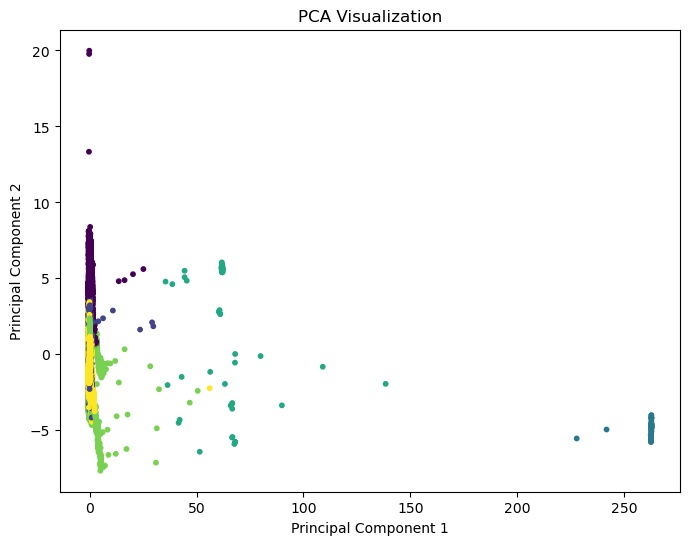

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, c=labels_0)
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [12]:
labels = labels + 5

In [13]:
labels.loc[index] = labels_0

In [14]:
combined_df = pd.concat([inputs, labels], axis=1)

In [15]:
combined_df.to_csv('swat_ieee754_knn6.csv', index=False)

测试损失函数

In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn

# 超参数
batch_size = 32
num_classes = 10
feature_dim = 128

# 随机生成一批样本数据和标签
logits = torch.randn(batch_size, num_classes)
labels = torch.randint(0, num_classes, (batch_size,))

In [6]:
class CustomLoss(nn.Module):
    def __init__(self, num_classes, alpha=1.0, beta=1.0):
        super(CustomLoss, self).__init__()
        self.num_classes = num_classes
        self.alpha = alpha
        self.beta = beta

    def forward(self, logits, labels):
        # 交叉熵损失
        ce_loss = F.cross_entropy(logits, labels)

        # 类内最小化 + 类间最大化
        prototypes = logits.mean(dim=0)  # 计算类别原型
        dists = F.pairwise_distance(logits, prototypes.unsqueeze(0).expand_as(logits))
        intra_loss = dists[labels == 0].mean()  # 类内损失(仅针对0类)
        
        # 其他类与0类原型的距离最大化
        inter_loss = -dists[labels != 0].mean()  # 针对其他类与0类原型的距离

        total_loss = self.alpha * ce_loss + self.beta * (intra_loss + inter_loss)
        return total_loss

In [7]:
# 实例化损失函数
custom_loss = CustomLoss(num_classes, alpha=1.0, beta=1.0)

In [8]:
# 计算损失
loss = custom_loss(logits, labels)
print(f"Total loss: {loss.item():.4f}")

IndexError: too many indices for tensor of dimension 1